In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/email-spam-detection-dataset-classification/spam.csv


In [2]:
data= pd.read_csv('/kaggle/input/email-spam-detection-dataset-classification/spam.csv', encoding= 'latin_1')
data.head()

v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [3]:
#Dropping the last 3 columns
data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)

In [4]:
#Renaming the columns to be understandable
data.rename(columns={'v1': 'Target', 'v2': 'Email'}, inplace=True)
data.head()

Target                                              Email
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...

In [5]:
#Mapping the target labels to 0 and 1
data['Target']=data['Target'].map({'ham': 0, 'spam': 1})

data.head()

Target                                              Email
0       0  Go until jurong point, crazy.. Available only ...
1       0                      Ok lar... Joking wif u oni...
2       1  Free entry in 2 a wkly comp to win FA Cup fina...
3       0  U dun say so early hor... U c already then say...
4       0  Nah I don't think he goes to usf, he lives aro...

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
#Setting a color palette
palette=sns.color_palette('magma')
sns.set(palette=palette)

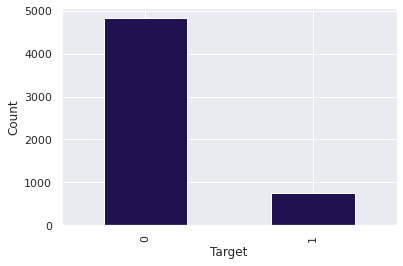

In [7]:
#Plotting Spam(1) vs Not Spam(0) value counts
data['Target'].value_counts().plot(kind='bar')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [8]:
#Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid= train_test_split(data['Email'], data['Target'], test_size=0.2, random_state=0)
X_train.head()

1114    No no:)this is kallis home ground.amla home to...
3589    I am in escape theatre now. . Going to watch K...
3095    We walked from my moms. Right on stagwood pass...
1012       I dunno they close oredi not... ÌÏ v ma fan...
3320                               Yo im right by yo work
Name: Email, dtype: object

In [9]:
#Funtion to build and visualise a confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def my_confusion_matrix(y_test, y_pred, plt_title, accuracy_title):
    cm=confusion_matrix(y_test, y_pred)
    print(f'{accuracy_title} Accuracy Score:', '{:.2%}'.format(accuracy_score(y_valid, y_pred)))
    print(classification_report(y_test, y_pred))
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap='magma')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(plt_title)
    plt.show()
    return cm

In [10]:
X_train.isnull().any()

False

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
#removing stopwords
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string if there are nans
#dataset['description'] = dataset['description'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix_train = tfidf.fit_transform(X_train)
tfidf_matrix_valid= tfidf.transform(X_valid)

tfidf_matrix_train.shape

(4457, 7351)

In [12]:
#Visualization to find the best K value
from sklearn.neighbors import KNeighborsClassifier
#To find the optimal k value: K=((Sqrt(N)/2)
#Visualisation for the Error Rate/K-value 
error_rate = []
for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i, metric = 'minkowski', p=1)
    knn.fit(tfidf_matrix_train, y_train)
    pred_i_knn = knn.predict(tfidf_matrix_train)
    error_rate.append(np.mean(pred_i_knn != y_train))
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

In [13]:
#Fitting the KMM model
knn_classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p=1)
knn_classifier.fit(tfidf_matrix_train, y_train)
y_pred_knn=knn_classifier.predict(tfidf_matrix_valid)
cm_knn=my_confusion_matrix(y_valid, y_pred_knn, 'KNN Confusion Matrix', 'KNN')

KNN Accuracy Score: 94.35%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       949
           1       1.00      0.62      0.77       166

    accuracy                           0.94      1115
   macro avg       0.97      0.81      0.87      1115
weighted avg       0.95      0.94      0.94      1115



Logistic Regression: Accuracy Score: 95.61%
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       949
           1       0.99      0.71      0.83       166

    accuracy                           0.96      1115
   macro avg       0.97      0.85      0.90      1115
weighted avg       0.96      0.96      0.95      1115



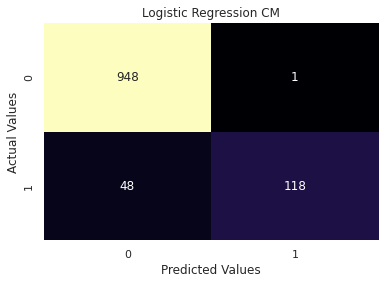

array([[948,   1],
       [ 48, 118]])

In [14]:
#Training the model
from sklearn.linear_model import LogisticRegression
log_reg_classifier=LogisticRegression(solver='liblinear')
log_reg_classifier.fit(tfidf_matrix_train, y_train)
y_pred_log=log_reg_classifier.predict(tfidf_matrix_valid)
my_confusion_matrix(y_valid, y_pred_log, 'Logistic Regression CM', 'Logistic Regression:')

In [15]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(tfidf_matrix_train, y_train)
y_pred_rfc=rfc.predict(tfidf_matrix_valid)
print(my_confusion_matrix(y_valid, y_pred_rfc, 'Random Forest', 'Random Forest'))

Random Forest Accuracy Score: 97.13%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       949
           1       1.00      0.81      0.89       166

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



[[949   0]
 [ 32 134]]


SVC Accuracy Score: 98.03%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       949
           1       0.99      0.87      0.93       166

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



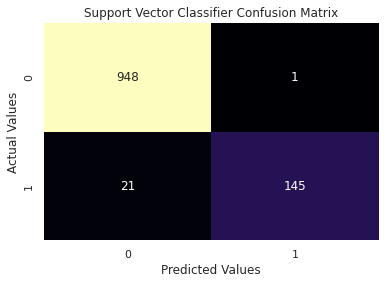

In [16]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', C=10)
svc.fit(tfidf_matrix_train, y_train)
y_pred_svc= svc.predict(tfidf_matrix_valid)
cm_svc=my_confusion_matrix(y_valid, y_pred_svc, 'Support Vector Classifier Confusion Matrix', 'SVC')

MLP Accuracy Score: 98.39%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       949
           1       0.99      0.90      0.94       166

    accuracy                           0.98      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



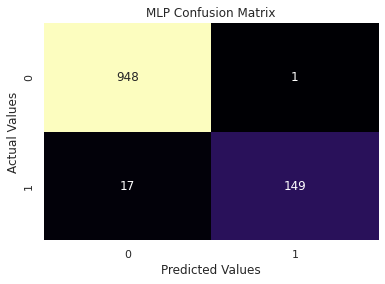

array([[948,   1],
       [ 17, 149]])

In [17]:
#MLP Classifier
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier()
mlp.fit(tfidf_matrix_train, y_train)
y_pred_mlp=mlp.predict(tfidf_matrix_valid)
my_confusion_matrix(y_valid, y_pred_mlp, 'MLP Confusion Matrix', 'MLP')

2022-03-07 10:17:35.485391: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-03-07 10:17:35.975341: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Neural Network Accuracy: Accuracy Score: 98.74%
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       949
           1       0.99      0.92      0.96       166

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



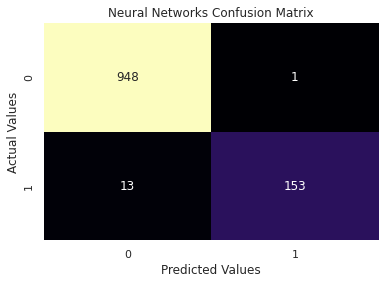

array([[948,   1],
       [ 13, 153]])

In [18]:
#Changing from csr matrix to array 
tfidf_matrix_train=tfidf_matrix_train.toarray()
tfidf_matrix_valid=tfidf_matrix_valid.toarray()
#Using Neural Networks
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(tfidf_matrix_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', # don't minimize the accuracy!
                   patience=10,
                   restore_best_weights=True)

NN_Classifier = model.fit(tfidf_matrix_train, y_train,
                    batch_size=100,
                    epochs=1000,
                    callbacks =[es],
                    verbose=0,
                    validation_data=(tfidf_matrix_valid, y_valid))

y_pred_NN=(model.predict(tfidf_matrix_valid) > 0.5).astype(int)
my_confusion_matrix(y_valid, y_pred_NN, 'Neural Networks Confusion Matrix', 'Neural Network Accuracy:')

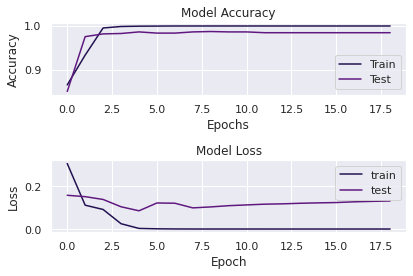

In [19]:
#Plotting Neural Network Training
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(NN_Classifier.history['accuracy'])
plt.plot(NN_Classifier.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(NN_Classifier.history['loss'])
plt.plot(NN_Classifier.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
plt.show()